In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNEL = 3
EPOCH = 30

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
            "../PlantVillage",
            shuffle = True,
            image_size = (IMAGE_SIZE, IMAGE_SIZE),
            batch_size = BATCH_SIZE 
           )

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

In [6]:
# 68*BATCH_SIZE 

# 2176

In [7]:
# for image_batch, label_batch in dataset.take(1):
#     print(image_batch.shape)
#     print(label_batch.numpy())

# (32, 256, 256, 3)
# [1 0 0 0 0 1 1 0 0 1 1 1 1 2 1 0 0 1 0 1 0 0 1 0 1 1 1 1 0 0 0 0]

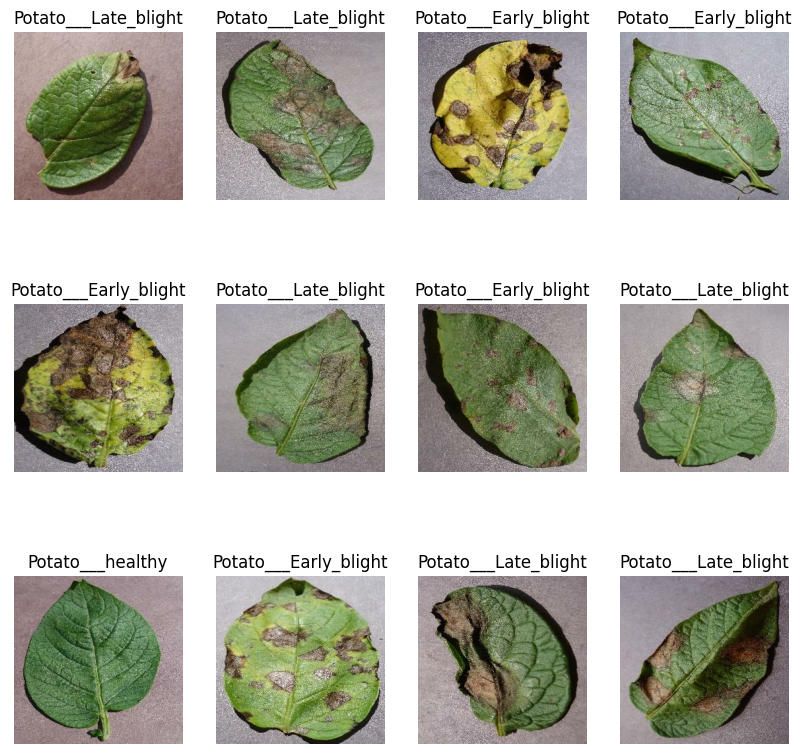

In [8]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [9]:
# 80% => Training
# 20% => 10% validation, 10% testing

In [10]:
train_size = 0.8
len(dataset) * train_size

54.400000000000006

In [11]:
train_ds = dataset.take(54) #raa[:54]
len(train_ds)

54

In [12]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [13]:
val_size = 0.1
len(dataset) * val_size

6.800000000000001

In [14]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [15]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
        ds_size = len(ds)

        if shuffle:
            ds = ds.shuffle(shuffle_size, seed=12)
    
        train_size = int(train_split * ds_size)
        val_size = int(val_split * ds_size)

        train_ds = ds.take(train_size)
        val_ds = ds.skip(train_size).take(val_size)
        test_ds = ds.skip(train_size).skip(val_size)
    
        return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)

54

In [19]:
len(val_ds)

6

In [20]:
len(test_ds)

8

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [22]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [23]:
# Data Augmentation -> If image is flip/rotate
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizonatal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [24]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNEL)
n_classes = 3
model = models.Sequential([
        resize_and_rescale,
        data_augmentation,
        layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(64, activation = 'relu'),
        layers.Dense(n_classes, activation = 'softmax')
])

model.build(input_shape = input_shape)

C:\Users\nisar\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics=['accuracy']
)

In [27]:
history = model.fit(
    train_ds,
    epochs = EPOCH,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 47s 760ms/step - accuracy: 0.4298 - loss: 0.9598 - val_accuracy: 0.5833 - val_loss: 0.9012
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 38s 702ms/step - accuracy: 0.6021 - loss: 0.8538 - val_accuracy: 0.7344 - val_loss: 0.5911
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 34s 630ms/step - accuracy: 0.7214 - loss: 0.6100 - val_accuracy: 0.8281 - val_loss: 0.4466
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 34s 637ms/step - accuracy: 0.8022 - loss: 0.4781 - val_accuracy: 0.8854 - val_loss: 0.2934
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 37s 681ms/step - accuracy: 0.8916 - loss: 0.2733 - val_accuracy: 0.8802 - val_loss: 0.2292
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 37s 683ms/step - accuracy: 0.9022 - loss: 0.2419 - val_accuracy: 0.8490 - val_loss: 0.3956
Epoch 7/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 49s 903ms/step - accuracy: 0.9148 - loss: 0.2362 - val_accuracy: 0.9323 - val_loss: 0.1387
Epoch 8/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 47s 871ms/step - accuracy: 0.9183 - loss: 0.1900 - val_accu

In [28]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 271ms/step - accuracy: 0.9584 - loss: 0.0953


In [29]:
scores

[0.10383233428001404, 0.94921875]

In [30]:
history

In [31]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 54}

In [32]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

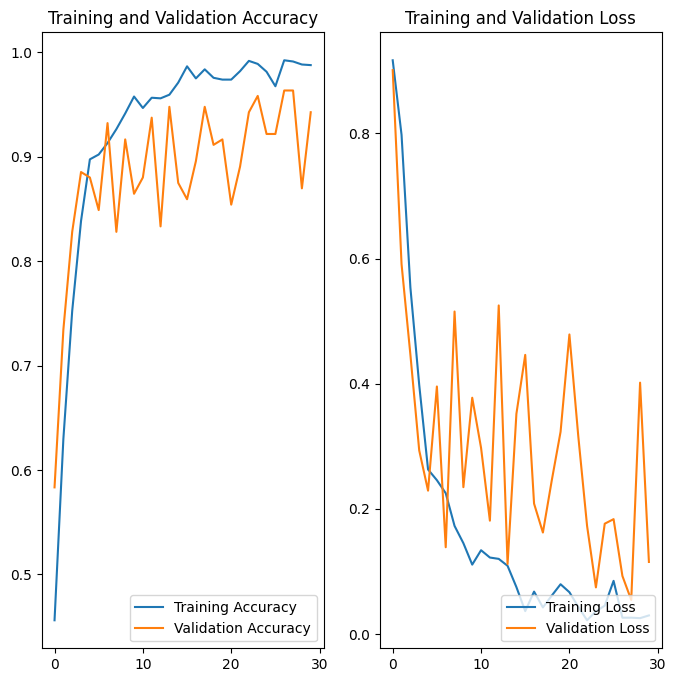

In [34]:
plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCH), acc, label = 'Training Accuracy')
plt.plot(range(EPOCH), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCH), loss, label = 'Training Loss')
plt.plot(range(EPOCH), val_loss, label = 'Validation Loss')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Loss')

First image to predict


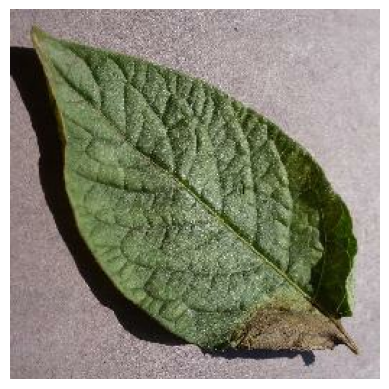

Actual Label :  Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
Predicted Label :  Potato___Late_blight


In [35]:
import numpy as np

# Take one batch from the test dataset
for image_batch, label_batch in test_ds.take(1):
    # Get the first image and label in the batch
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()

    # Display the image
    print("First image to predict")
    plt.imshow(first_image)
    plt.axis('off')  # hides axis
    plt.show()

    # Print the actual label
    print("Actual Label : ", class_names[first_label])
    
    # Predict the label for the entire batch
    batch_prediction = model.predict(image_batch)
    
    # Get the predicted class of the first image
    predicted_class = np.argmax(batch_prediction[0])
    print("Predicted Label : ", class_names[predicted_class])

In [36]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img.numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array, verbose=0)
    
    predicted_index = np.argmax(predictions[0])
    predicted_class = class_names[predicted_index]
    
    confidence = round(100 * np.max(predictions[0]), 2)
    
    return predicted_class, confidence

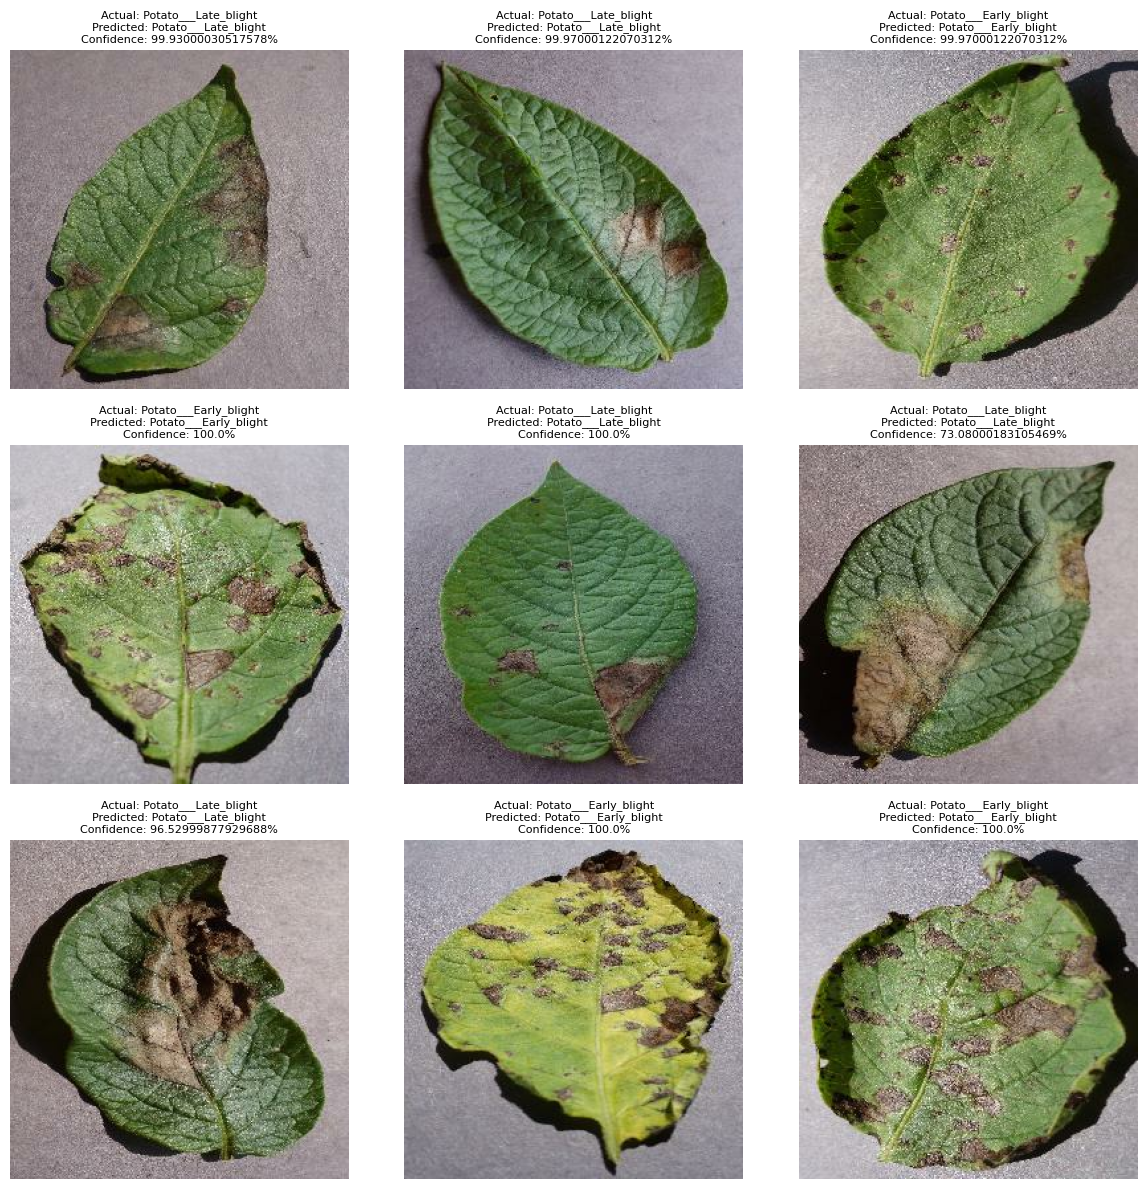

In [37]:
plt.figure(figsize=(12, 12))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[labels[i].numpy()]

        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%", fontsize=8)
        plt.axis("off")
        
plt.tight_layout()
plt.show()

In [38]:
import os
model_version = max([int(i) for i in os.listdir("../Store-Model") + [0]]) + 1
model.save(f"../Store-Model/{model_version}.keras")